In [1]:
import os
import random
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm_notebook
from PIL import Image

import torch
import timm
from torch import nn, optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from ranger import Ranger
#https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
from torchelie.loss import TemperedCrossEntropyLoss
#https://github.com/Vermeille/Torchelie
from sklearn.model_selection import train_test_split
from sklearn import metrics
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)
from albumentations.pytorch import ToTensorV2
import seaborn as sns

import logging
logging.getLogger().setLevel(logging.INFO)

import warnings
warnings.filterwarnings('ignore')


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    logging.info(f"Running on {torch.cuda.get_device_name()}")
else:
    device = torch.device("cpu")
    logging.info("Running on a CPU")
    

INFO:root:Running on GeForce GTX 1060 6GB


In [3]:
#seed everything for reproducibility
seed = 55555

random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [4]:
georges, non_georges = pd.read_csv(r"georges.csv", header=None), pd.read_csv(r"non_georges.csv", header=None)
georges['label'], non_georges['label'] = 1, 0
dataframes = [georges, non_georges]
paths = {"georges":"./georges/", "non_georges":"./non_georges/"}


In [5]:
#download data
for path, dataframe in zip(paths, dataframes):
    if not os.path.exists(path):
        os.makedirs(path)

    for number, picture in tqdm_notebook(enumerate(dataframe[:][0])):
        image = requests.get(picture).content
        with open(paths[path] + str(number) + ".jpg", 'wb') as f:
            f.write(image)


In [6]:
#replace image links with local paths in both dataframes
for path, dataframe in zip(paths, dataframes):
    image_paths = [paths[path] + name for name in os.listdir(path)]
    dataframe[0] = image_paths
    

In [7]:
#create training, validation and test dataframes
#this implementation doesn't include generic 5-fold CV
df = pd.concat(dataframes)
train_df, test_df = train_test_split(df, test_size=0.1, random_state=seed, shuffle=True)
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=seed, shuffle=True)


In [8]:
#hyperparameters
image_size = 350
batch_size = 20
gradient_accumulation_steps = 10
learning_rate = 0.0005
epochs = 35

label_counts = df.label.value_counts(sort = False)


In [9]:
#custom dataset class that augments data during training
#imagenet normalization is used for efficientnet fine-tuning

class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, mode="train", transforms=None):
        super().__init__()
        self.df_data = df.values
        self.transforms = transforms
        self.mode = mode

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        image_path, label = self.df_data[index]
        image = Image.open(image_path)
        image = np.array(image)

        if image.shape[-1] == 4: #removing alpha channel
            image = image[..., :3]
        if len(image.shape) == 2: #converting single channel image to 3 channel
            image = np.stack((image,)  *3, axis = -1)

        if self.transforms is not None:
            image = self.transforms(image=image)["image"]

        return image, label

#data augmentation used both for training and validation
#When and Why Test-Time Augmentation Works:
#https://arxiv.org/abs/2011.11156

transform = Compose([
            RandomResizedCrop(image_size, image_size),
            Transpose(p = 0.5),
            HorizontalFlip(p = 0.4),
            VerticalFlip(p = 0.4),
            ShiftScaleRotate(p = 0.3),
            MedianBlur(blur_limit = 7, always_apply = False, p = 0.3),
            IAAAdditiveGaussianNoise(scale = (0, 0.15 * 255), p = 0.5),
            HueSaturationValue(hue_shift_limit = 0.2, sat_shift_limit = 0.2, val_shift_limit = 0.2, p = 0.4),
            RandomBrightnessContrast(brightness_limit = (-0.1, 0.1), contrast_limit = (-0.1, 0.1), p = 0.5),
            Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225], max_pixel_value = 255.0, p = 1.0),
            CoarseDropout(p = 0.1),
            Cutout(p = 0.4),
            ToTensorV2(p = 1.0),
        ], p = 1.)

tta_transform = Compose([
            Resize(image_size, image_size, p = 1.0),            
            HorizontalFlip(p = 1.0),        
            Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value = 255.0, p = 1.0),
            ToTensorV2(p = 1.0),
        ], p = 1.0)

test_transform = Compose([
            Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225], max_pixel_value = 255.0, p = 1.0),
            ToTensorV2(p = 1.0),
        ], p = 1.0)

train_dataset, valid_dataset = Dataset(train_df, transforms = transform), Dataset(valid_df, transforms = transform)


In [10]:
from torch.utils.data import DataLoader, SequentialSampler
from catalyst.data.sampler import BalanceClassSampler

train_dataloader = DataLoader(
            train_dataset,
            #balanced sampler is used to minimize harmful effects of dataset not being fully balanced
            sampler=BalanceClassSampler(labels=train_df.label.values, mode="downsampling"),
            batch_size = batch_size)
valid_dataloader = DataLoader(
            valid_dataset,
            sampler = SequentialSampler(valid_dataset),
            batch_size = batch_size)


In [11]:
class Grisha_Classifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)
        
    def forward(self, x):
        x = self.model(x)
        #x = F.softmax(x, dim = 1)
        return x

net = Grisha_Classifier("tf_efficientnet_b3_ns", len(label_counts)).to(device)
#EfficientNet: https://arxiv.org/abs/1905.11946
#fine tuning the efficientnet for 2 labels output
#in this implementation, no weights are frozen
#ideally, batchnorm layers can be frozen for marginal training speed increase


In [12]:
import copy
loss_function = TemperedCrossEntropyLoss(t1 = 0.3, t2 = 1.7)
#Bi-Tempered Logistic Loss for Training Neural Nets with Noisy Data:
#https://ai.googleblog.com/2019/08/bi-tempered-logistic-loss-for-training.html
#https://github.com/google/bi-tempered-loss
#provides increase in accuracy on noisy data
#optimizer = optim.AdamW(net.parameters(), lr = learning_rate, weight_decay = 0.9, betas = (0.9, 0.999))
optimizer = Ranger(net.parameters(), lr = learning_rate, weight_decay = 0.9, betas = (0.9, 0.999))
scheduler = CosineAnnealingLR(optimizer, epochs * 0.3, learning_rate * 0.0001)
scheduler.last_epoch = epochs
scaler = GradScaler()

def training_loop():
    best_model_wts = copy.deepcopy(net.state_dict())
    best_loss = 100
    
    for epoch in (range(epochs)):
        if epoch != 0 and epoch > 0.3 * epochs:
            scheduler.step()
        logging.info(f"Epoch {epoch+1}")

        logging.info("Training")
        train_losses, train_accuracies = forward_pass(train_dataloader, train = True)  

        logging.info("Validating")
        val_losses, val_accuracies = forward_pass(valid_dataloader)

        logging.info(f"Training accuracy:   {sum(train_accuracies)/len(train_accuracies)} | Training loss: {sum(train_losses)/len(train_losses)}")
        logging.info(f"Validation accuracy: {sum(val_accuracies)/len(val_accuracies)} | Validation loss: {sum(val_losses)/len(val_losses)}")
        
        epoch_val_loss = sum(val_losses)/len(val_losses)
        
        if best_loss > epoch_val_loss:    
            best_loss = epoch_val_loss
            best_model_wts = copy.deepcopy(net.state_dict())
            torch.save(net.state_dict(), "best.pth")
            logging.info(f"Saving with loss of {epoch_val_loss}, improved over previous {best_loss}")


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


In [13]:
def forward_pass(dataloader, test = False, train = False):
    if train:
        net.train()
    else:
        net.eval()

    losses = []
    accuracies = []

    for step, batch in (enumerate(dataloader)):
        inputs = batch[0].to(device).float()
        labels = batch[1].to(device).long()

        with autocast():
            if train:
                outputs = net(inputs)  
                loss = loss_function(outputs, labels)
                scaler.scale(loss).backward()
            else:
                with torch.no_grad():
                    outputs = net(inputs)  
                    loss = loss_function(outputs, labels)        

        matches = [torch.argmax(i) == j for i, j in zip(outputs, labels)]        
        acc = matches.count(True)/len(matches)                               
        losses.append(loss)
        accuracies.append(acc)
        
        if train and (step+1) % gradient_accumulation_steps == 0:
        #gradient accumulation to train with bigger effective batch size 
        #with less memory use
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()            
            logging.info(f"Step {step} of {len(train_dataloader)}, Accuracy: {sum(accuracies)/len(accuracies)}, Loss: {sum(losses)/len(losses)}")    
    return losses, accuracies

def test():
    net.eval()    
    logging.info("Testing")

    test_labels = []
    tta_test_outputs = []
    tta_test_losses = [] 
    test_outputs = []       
    test_losses = []        

    for step, batch in enumerate(zip(test_dataloader, tta_test_dataloader)):        
        test_inputs = batch[0][0].to(device).float()
        aug_test_inputs = batch[1][0].to(device).float()
        test_label = batch[0][1].to(device).long()

        with torch.no_grad():
                    output = net(test_inputs)
                    loss = loss_function(output, test_label)
                    aug_output = net(aug_test_inputs)                    
                    aug_loss = loss_function(aug_output, test_label)
        test_labels.append(int(test_label))
        test_outputs.append(int(torch.argmax(output).item()))
        test_losses.append(loss)
        matches = [i == j for i, j in zip(test_outputs, test_labels)]

        tta_output = torch.stack((output, aug_output)).mean(dim=0)
        tta_test_outputs.append(int(torch.argmax(tta_output).item()))
        tta_test_losses.append((loss+aug_loss)/2)
        tta_matches = [i == j for i, j in zip(tta_test_outputs, test_labels)]                
    
    cf_matrix = metrics.confusion_matrix(test_labels, test_outputs)
    cf_labels = ["True Negative", "False Positive", "False Negative", "True Positive"]
    cf_labels = np.asarray(cf_labels).reshape(2,2)    
    sns.heatmap(cf_matrix, annot=cf_labels, fmt="", cmap='Blues')
    
    logging.info(f"Final test loss is {sum(test_losses)/len(test_losses)}")
    logging.info(f"Final test accuracy is {matches.count(True)/len(matches)}")

    logging.info(f"Final TTA test loss is {sum(tta_test_losses)/len(tta_test_losses)}")
    logging.info(f"Final TTA test accuracy is {tta_matches.count(True)/len(tta_matches)}")


In [14]:
training_loop()
#the best model will be saved and loaded later for the final test



INFO:root:Validation accuracy: 0.90979797979798 | Validation loss: 0.0948745384812355
INFO:root:Epoch 25
INFO:root:Training
INFO:root:Step 9 of 193, Accuracy: 0.9649999999999999, Loss: 0.04234927520155907
INFO:root:Step 19 of 193, Accuracy: 0.9549999999999997, Loss: 0.05173802375793457
INFO:root:Step 29 of 193, Accuracy: 0.9599999999999997, Loss: 0.0451495535671711
INFO:root:Step 39 of 193, Accuracy: 0.95875, Loss: 0.04802372679114342
INFO:root:Step 49 of 193, Accuracy: 0.953, Loss: 0.051827047020196915
INFO:root:Step 59 of 193, Accuracy: 0.9458333333333333, Loss: 0.057158321142196655
INFO:root:Step 69 of 193, Accuracy: 0.947857142857143, Loss: 0.05459742620587349
INFO:root:Step 79 of 193, Accuracy: 0.9481250000000003, Loss: 0.0542110875248909
INFO:root:Step 89 of 193, Accuracy: 0.9483333333333337, Loss: 0.053282856941223145
INFO:root:Step 99 of 193, Accuracy: 0.9490000000000006, Loss: 0.05333587899804115
INFO:root:Step 109 of 193, Accuracy: 0.9481818181818188, Loss: 0.054403610527515

In [15]:
test_dataset = Dataset(test_df, transforms = test_transform)
test_dataset_tta = Dataset(test_df, transforms = tta_transform)

test_dataloader = DataLoader(
                test_dataset,
                sampler = SequentialSampler(test_dataset),
                batch_size = 1)
                
tta_test_dataloader = DataLoader(
                test_dataset_tta,
                sampler = SequentialSampler(test_dataset_tta),
                batch_size = 1)


In [16]:
net.load_state_dict(torch.load('best.pth'))
net.eval()
logging.info("State dict loaded successfully")


INFO:root:State dict loaded successfully


INFO:root:Testing
INFO:root:Final test loss is 0.05637577176094055
INFO:root:Final test accuracy is 0.9454545454545454
INFO:root:Final TTA test loss is 0.059158824384212494
INFO:root:Final TTA test accuracy is 0.9454545454545454


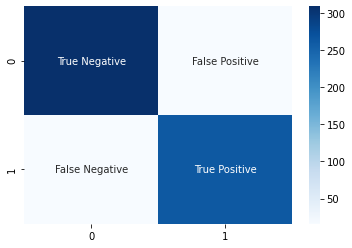

In [17]:
test()
#basic TTA doesn't increase the overall accuracy
#might change with increased amount of augmented inputs